In [1]:
import numpy as np
import pandas as pd

In [2]:
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow import keras 
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import LSTM, GRU, Dense, RepeatVector, TimeDistributed, Input, BatchNormalization, \
    multiply, concatenate, Flatten, Activation, dot
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 2618331821479328891
xla_global_id: -1
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 10311761920
locality {
  bus_id: 1
  links {
  }
}
incarnation: 460552901598335825
physical_device_desc: "device: 0, name: NVIDIA GeForce GTX 1080 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1"
xla_global_id: 416903419
]


2022-08-01 14:58:37.323012: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-08-01 14:58:37.372116: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 14:58:37.377316: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-08-01 14:58:37.377566: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zer

In [30]:
DATA = 'integrase'
MODEL_SUFFIX = '5_random_randomized'

In [31]:
import matplotlib.pyplot as plt

%matplotlib inline
plt.rcParams['figure.figsize'] = (16, 8)

In [32]:
with np.load(f'data/{DATA}/train_cut.npz', allow_pickle = True) as data:
    X = data['parents']
    Y = data['children']
    V = data['vocab_index'].tolist()

In [33]:
print(X.shape)
print(Y.shape)
print(V)

(16032, 289, 23)
(16032, 289, 23)
{'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'G': 6, 'H': 7, 'I': 8, 'K': 9, 'L': 10, 'M': 11, 'N': 12, 'P': 13, 'Q': 14, 'R': 15, 'S': 16, 'T': 17, 'V': 18, 'W': 19, 'X': 20, 'Y': 21, 'Z': 22}


In [34]:
W = dict((i, char) for char, i in V.items())
decode_seq = lambda seq: [ ''.join([ W[i] for i in s ]) for s in np.argmax(seq, axis = 2)]

In [35]:
i = 5
print(decode_seq(X[i:i+1])[0])
print(decode_seq(Y[i:i+1])[0])

FLDGIDKAQDEHEKYHSNWRAMASDFNLPPVVAKEIVASCDKCQLKGEAMHGQVDCSPGIWQLDCTHLEGKVILVAVHVASGYIEAEVIPAETGQETAYFLLKLAGRWPVKAIHTDNGSNFTSATVKAACWWAGIKQEFGIPYNPQSQGVVESMNKELKKIIGQVRDQAEHLKTAVQMAVFIHNFKRKGGIGGYSAGERIIDIIATDIQTKELQKQITKIQNFRVYYRDSRDPLWKGPAKLLWKGEGAVVIQDNSDIKVVPRRKAKIIRDYGKQMAGDDCVASRQDEDA
FLDGIDKAQDEHEKYHSNWRAMASDFNLPPVVAKEIVASCDKCQLKGEAMHGQVDCSPGIWQLDCTHLEGKVILVAVHVASGYIEAEVIPAETGQETAYFILKLAGRWPVKTVHTDNGSNFTSATVKAACWWAGIKQEFGIPYNPQSQGVVESINKELKKIIGQIRDQAEHLKTAVQMAVFIHNFKRKGGIGGYSAGERIIDIIATDIQTKELQKQITKIQNFRVYYRDSRDPLWKGPAKLLWKGEGAVVIQDNSDIKVVPRRKAKIIRDYGKQMAGDDCVASRQDEDA


## Modelis

In [36]:
len(decode_seq(X[i:i+1])[0])

289

In [37]:
n_hidden = 16

# (1, 289)(17, 17)
n_length = 17
n_splits = X.shape[1] // n_length

n_hidden, n_length, n_splits

(16, 17, 17)

In [38]:
input_train = Input(shape=(X.shape[1], X.shape[2]), name="parent_input")
input_rand_rate = Input(shape=(), name="random_input")
output_train = Input(shape=(Y.shape[1], Y.shape[2]), name="child_output")

print(input_train)
print(input_rand_rate)
print(output_train)

KerasTensor(type_spec=TensorSpec(shape=(None, 289, 23), dtype=tf.float32, name='parent_input'), name='parent_input', description="created by layer 'parent_input'")
KerasTensor(type_spec=TensorSpec(shape=(None,), dtype=tf.float32, name='random_input'), name='random_input', description="created by layer 'random_input'")
KerasTensor(type_spec=TensorSpec(shape=(None, 289, 23), dtype=tf.float32, name='child_output'), name='child_output', description="created by layer 'child_output'")


In [39]:
splits = tf.split(input_train, num_or_size_splits=n_splits, axis=1)
concat = tf.concat(splits, axis=0)
print(concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 23), dtype=tf.float32, name=None), name='tf.concat_2/concat:0', description="created by layer 'tf.concat_2'")


In [40]:
encoder_stack_h, encoder_last_h = GRU(
    n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
    return_sequences = True, return_state = True)(concat)
print(encoder_stack_h)
print(encoder_last_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 16), dtype=tf.float32, name=None), name='gru_2/transpose_1:0', description="created by layer 'gru_2'")
KerasTensor(type_spec=TensorSpec(shape=(None, 16), dtype=tf.float32, name=None), name='gru_2/while:4', description="created by layer 'gru_2'")


In [41]:
encoder_last_h = BatchNormalization(momentum = 0.6)(encoder_last_h)
decoder_input = RepeatVector(concat.shape[1])(encoder_last_h)
print(decoder_input)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 16), dtype=tf.float32, name=None), name='repeat_vector_1/Tile:0', description="created by layer 'repeat_vector_1'")


In [42]:
decoder_stack_h = GRU(n_hidden, dropout = 0.01, recurrent_dropout = 0.01,
 return_state = False, return_sequences = True)(
 decoder_input, initial_state = encoder_last_h)
print(decoder_stack_h)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 16), dtype=tf.float32, name=None), name='gru_3/transpose_1:0', description="created by layer 'gru_3'")


In [43]:
attention = dot([decoder_stack_h, encoder_stack_h], axes = [2, 2])
attention = Activation('softmax')(attention)
print(attention)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 17), dtype=tf.float32, name=None), name='activation_1/Softmax:0', description="created by layer 'activation_1'")


In [44]:
class RandomDropout(keras.layers.Layer):
    
    def call(self, inputs, rate):
        return tf.nn.dropout(inputs, rate=rate[0])
    

In [45]:
context = dot([attention, encoder_stack_h], axes = [2,1])
context = BatchNormalization(momentum = 0.6)(context)
context = RandomDropout()(context, input_rand_rate)
print(context)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 16), dtype=tf.float32, name=None), name='random_dropout_1/dropout/Mul:0', description="created by layer 'random_dropout_1'")


In [46]:
decoder_combined_context = concatenate([context, decoder_stack_h])
print(decoder_combined_context)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 32), dtype=tf.float32, name=None), name='concatenate_1/concat:0', description="created by layer 'concatenate_1'")


In [47]:
out = TimeDistributed(Dense(concat.shape[2], activation = "softmax"))(decoder_combined_context)
print(out)

KerasTensor(type_spec=TensorSpec(shape=(None, 17, 23), dtype=tf.float32, name=None), name='time_distributed_1/Reshape_1:0', description="created by layer 'time_distributed_1'")


In [48]:
back_splits = tf.split(out, num_or_size_splits=n_splits, axis=0)
back_concat = tf.concat(back_splits, axis=1)
print(back_concat)

KerasTensor(type_spec=TensorSpec(shape=(None, 289, 23), dtype=tf.float32, name=None), name='tf.concat_3/concat:0', description="created by layer 'tf.concat_3'")


In [49]:
model = Model(inputs = [input_train, input_rand_rate], outputs = back_concat)
opt = keras.optimizers.Adam(learning_rate = 0.1, clipnorm = 1, amsgrad = True)
model.compile(loss = 'categorical_crossentropy', optimizer = opt, metrics = ['accuracy'])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 parent_input (InputLayer)      [(None, 289, 23)]    0           []                               
                                                                                                  
 tf.split_2 (TFOpLambda)        [(None, 17, 23),     0           ['parent_input[0][0]']           
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                            

                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23),                                                  
                                 (None, 17, 23)]                                                  
                                                                                                  
 tf.concat_3 (TFOpLambda)       (None, 289, 23)      0           ['tf.split_3[0][0]',             
          

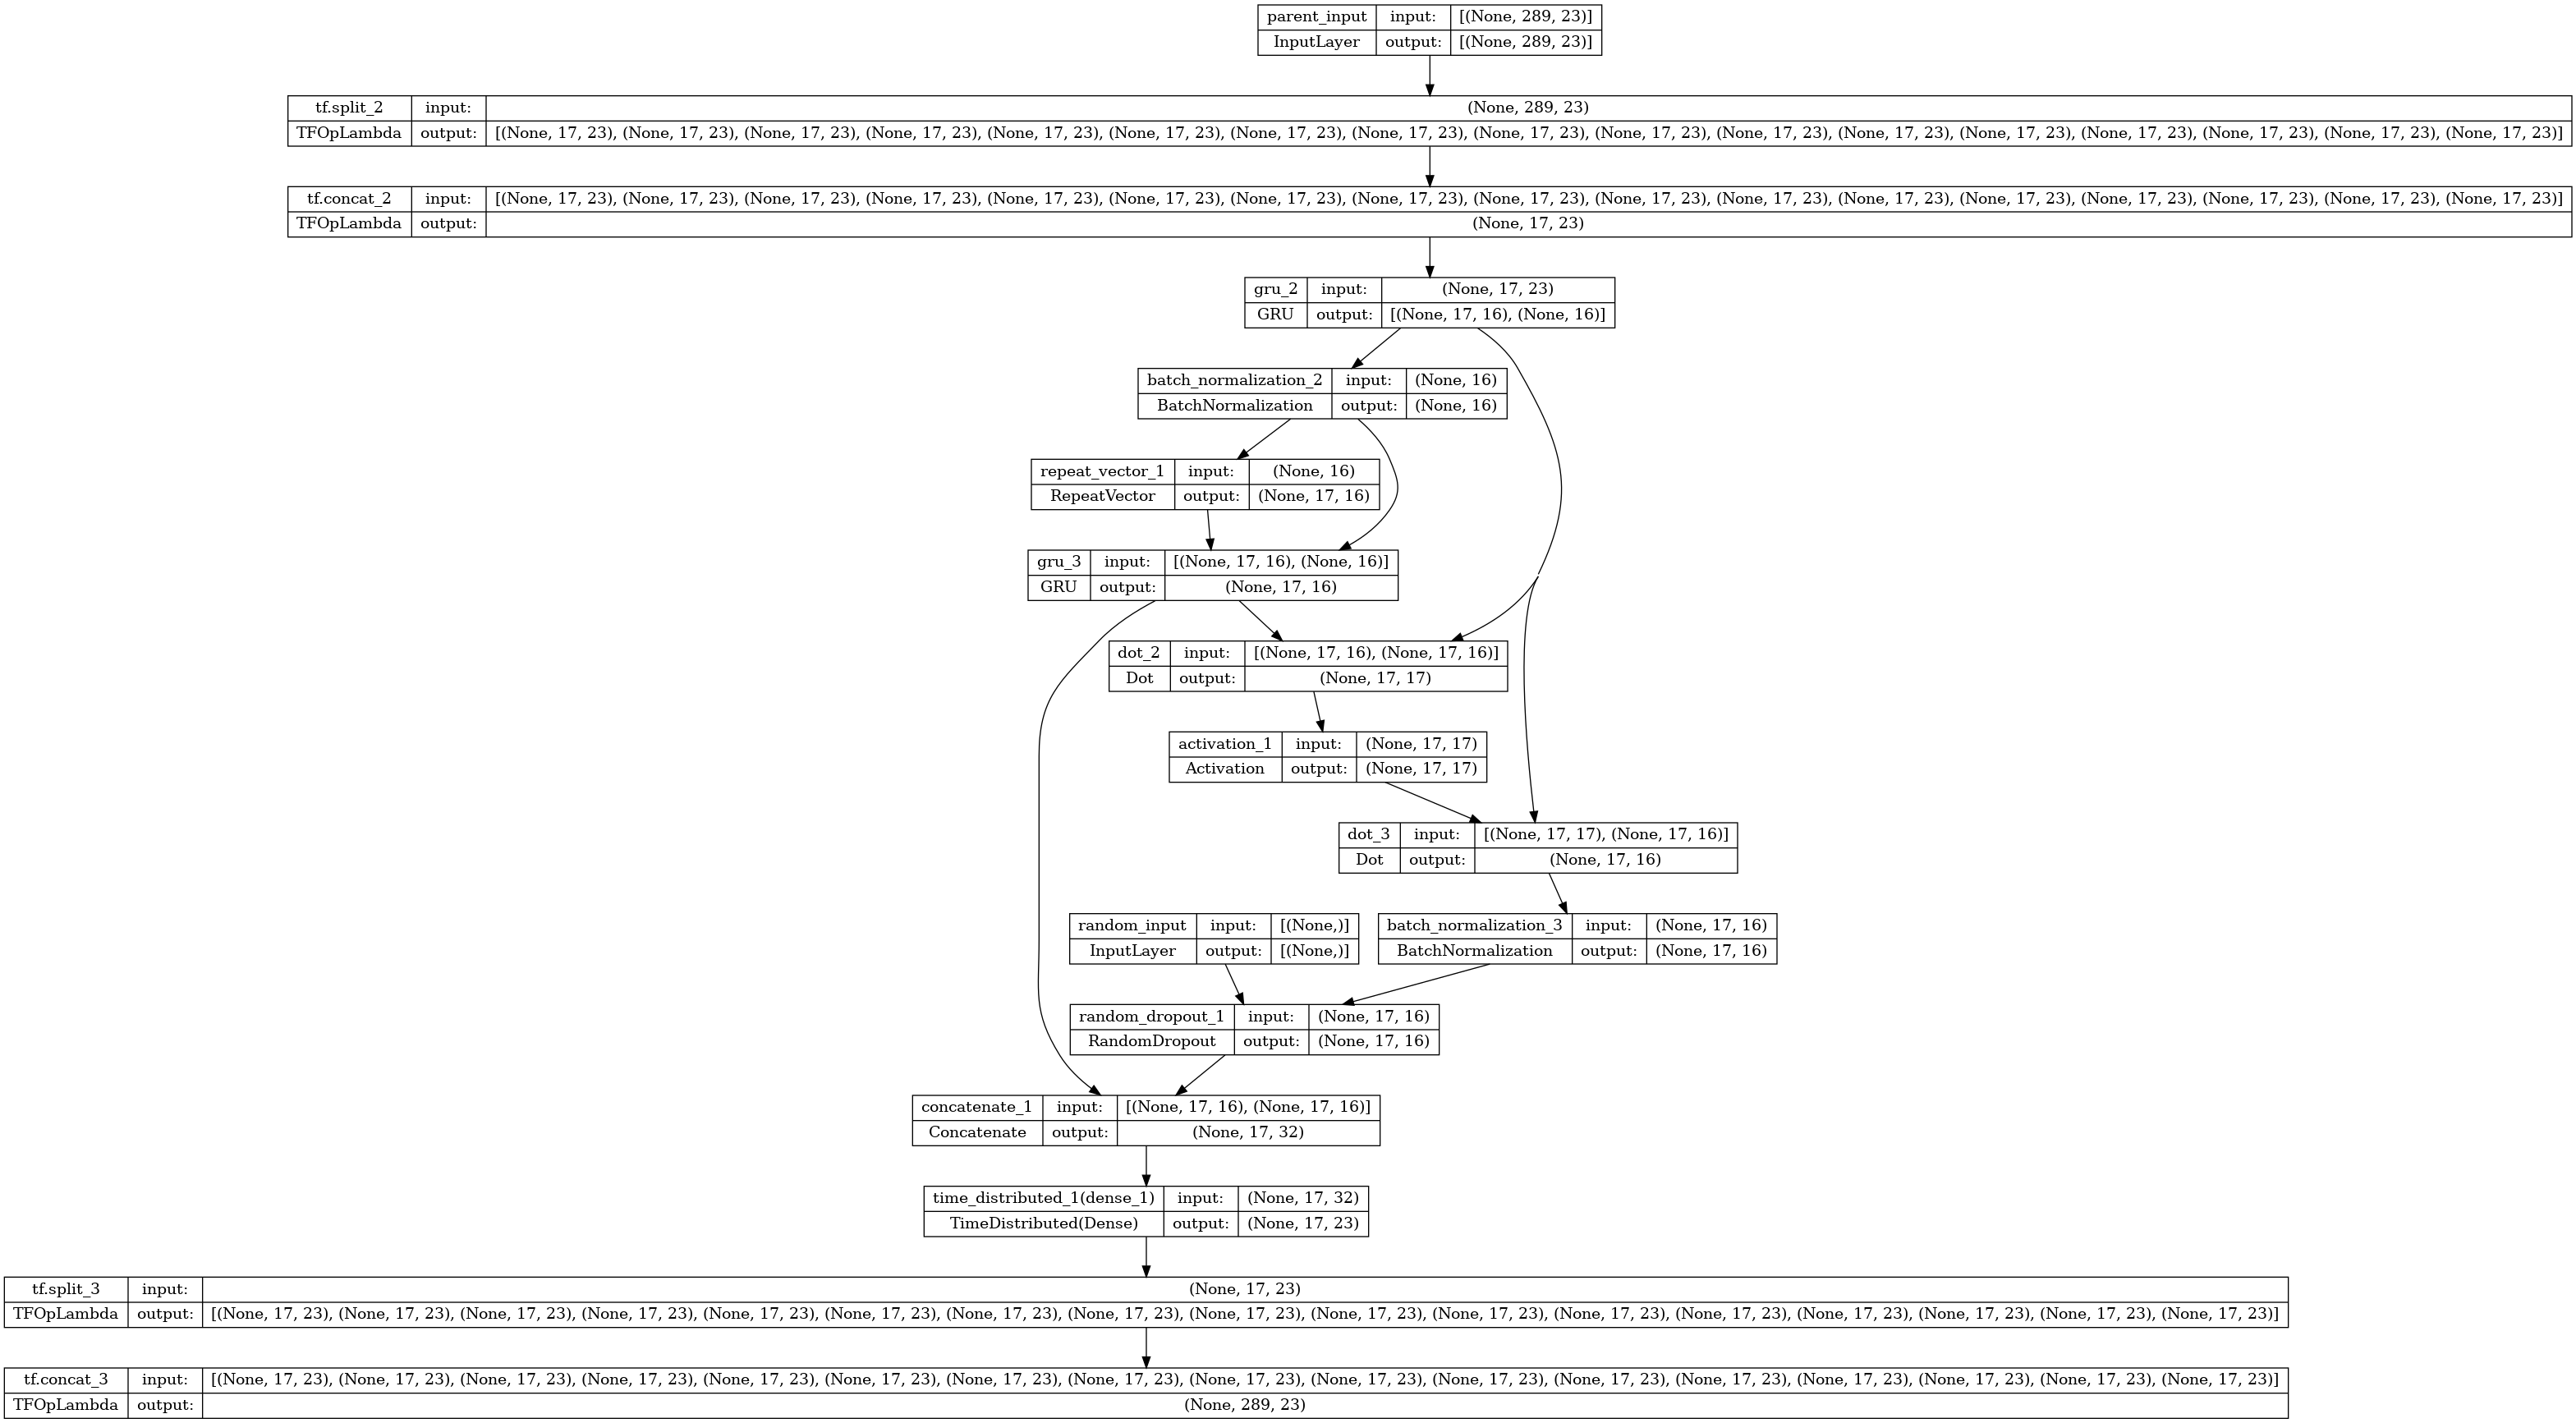

In [50]:
keras.utils.plot_model(model, to_file = f'model_{DATA}_{MODEL_SUFFIX}_plot.png', show_shapes = True, show_layer_names = True)

## Train

In [53]:
batch_size = 64      # Batch size for training.
patience = 400        # Patience for EarlyStop
epochs = 1500        # Number of epochs to train for.
# rand_rate = np.full((len(X)), 0.089)
rand_rate = np.random.uniform(0.01, 0.089, len(X),)
rand_rate.shape

(16032,)

In [54]:
es = EarlyStopping(monitor = 'val_loss', mode = 'min', patience = patience, restore_best_weights = True)
history = model.fit([ X, rand_rate ], Y, 
                    validation_split = 0.2, 
                    epochs = epochs, verbose = 1, callbacks = [ es ], 
                    batch_size = batch_size)

# train_mae = history.history['accuracy']
# valid_mae = history.history['val_accuracy']

Epoch 1/1500
201/201 [==============================] - 11s 57ms/step - loss: 1.1504 - accuracy: 0.6199 - val_loss: 0.9951 - val_accuracy: 0.7428
Epoch 2/1500
201/201 [==============================] - 11s 54ms/step - loss: 1.1937 - accuracy: 0.6259 - val_loss: 1.0792 - val_accuracy: 0.7295
Epoch 3/1500
201/201 [==============================] - 11s 54ms/step - loss: 1.4621 - accuracy: 0.5473 - val_loss: 2.4556 - val_accuracy: 0.2554
Epoch 4/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.7411 - accuracy: 0.4351 - val_loss: 1.4799 - val_accuracy: 0.5739
Epoch 5/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.3962 - accuracy: 0.5521 - val_loss: 1.4805 - val_accuracy: 0.5588
Epoch 6/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.6693 - accuracy: 0.4613 - val_loss: 2.3574 - val_accuracy: 0.2700
Epoch 7/1500
201/201 [==============================] - 11s 55ms/step - loss: 1.8750 - accuracy: 0.3926 - val_loss: 1.6448 -

Epoch 57/1500
201/201 [==============================] - 11s 55ms/step - loss: 1.0275 - accuracy: 0.6999 - val_loss: 1.1834 - val_accuracy: 0.6858
Epoch 58/1500
201/201 [==============================] - 11s 54ms/step - loss: 1.0485 - accuracy: 0.6889 - val_loss: 1.1994 - val_accuracy: 0.6888
Epoch 59/1500
201/201 [==============================] - 11s 55ms/step - loss: 1.0338 - accuracy: 0.6947 - val_loss: 1.2323 - val_accuracy: 0.6787
Epoch 60/1500
201/201 [==============================] - 11s 55ms/step - loss: 1.0679 - accuracy: 0.6843 - val_loss: 1.2558 - val_accuracy: 0.6673
Epoch 61/1500
201/201 [==============================] - 11s 55ms/step - loss: 1.0088 - accuracy: 0.7065 - val_loss: 1.4688 - val_accuracy: 0.6062
Epoch 62/1500
201/201 [==============================] - 11s 54ms/step - loss: 1.1912 - accuracy: 0.6493 - val_loss: 1.2463 - val_accuracy: 0.6760
Epoch 63/1500
201/201 [==============================] - 11s 54ms/step - loss: 1.1086 - accuracy: 0.6726 - val_loss: 1

201/201 [==============================] - 11s 55ms/step - loss: 1.3370 - accuracy: 0.5691 - val_loss: 1.4407 - val_accuracy: 0.5815
Epoch 168/1500
201/201 [==============================] - 11s 54ms/step - loss: 1.3564 - accuracy: 0.5649 - val_loss: 1.4510 - val_accuracy: 0.5788
Epoch 169/1500
201/201 [==============================] - 11s 56ms/step - loss: 1.3094 - accuracy: 0.5791 - val_loss: 1.4335 - val_accuracy: 0.5912
Epoch 170/1500
201/201 [==============================] - 11s 55ms/step - loss: 1.3179 - accuracy: 0.5781 - val_loss: 1.4751 - val_accuracy: 0.5637
Epoch 171/1500
201/201 [==============================] - 11s 54ms/step - loss: 1.3260 - accuracy: 0.5753 - val_loss: 1.4568 - val_accuracy: 0.5768
Epoch 172/1500
201/201 [==============================] - 11s 55ms/step - loss: 1.3046 - accuracy: 0.5836 - val_loss: 1.4279 - val_accuracy: 0.6019
Epoch 173/1500
201/201 [==============================] - 11s 54ms/step - loss: 1.3150 - accuracy: 0.5788 - val_loss: 1.4361 - 

201/201 [==============================] - 11s 52ms/step - loss: 1.3077 - accuracy: 0.5750 - val_loss: 1.4357 - val_accuracy: 0.5855
Epoch 278/1500
201/201 [==============================] - 11s 52ms/step - loss: 1.3060 - accuracy: 0.5760 - val_loss: 1.4329 - val_accuracy: 0.5819
Epoch 279/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.3441 - accuracy: 0.5672 - val_loss: 1.4829 - val_accuracy: 0.5728
Epoch 280/1500
201/201 [==============================] - 11s 52ms/step - loss: 1.2835 - accuracy: 0.5823 - val_loss: 1.4316 - val_accuracy: 0.5934
Epoch 281/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.2641 - accuracy: 0.5895 - val_loss: 1.4280 - val_accuracy: 0.6009
Epoch 282/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.2658 - accuracy: 0.5886 - val_loss: 1.4312 - val_accuracy: 0.6008
Epoch 283/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.3097 - accuracy: 0.5757 - val_loss: 1.4686 - 

201/201 [==============================] - 11s 53ms/step - loss: 1.2263 - accuracy: 0.5995 - val_loss: 1.3799 - val_accuracy: 0.6045
Epoch 388/1500
201/201 [==============================] - 11s 52ms/step - loss: 1.2270 - accuracy: 0.5986 - val_loss: 1.4031 - val_accuracy: 0.5985
Epoch 389/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.2447 - accuracy: 0.5941 - val_loss: 1.3727 - val_accuracy: 0.6072
Epoch 390/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.2215 - accuracy: 0.6010 - val_loss: 1.3752 - val_accuracy: 0.6081
Epoch 391/1500
201/201 [==============================] - 11s 52ms/step - loss: 1.2185 - accuracy: 0.6025 - val_loss: 1.3867 - val_accuracy: 0.5890
Epoch 392/1500
201/201 [==============================] - 11s 53ms/step - loss: 1.2218 - accuracy: 0.6017 - val_loss: 1.3632 - val_accuracy: 0.6076
Epoch 393/1500
201/201 [==============================] - 11s 52ms/step - loss: 1.2131 - accuracy: 0.6051 - val_loss: 1.3602 - 

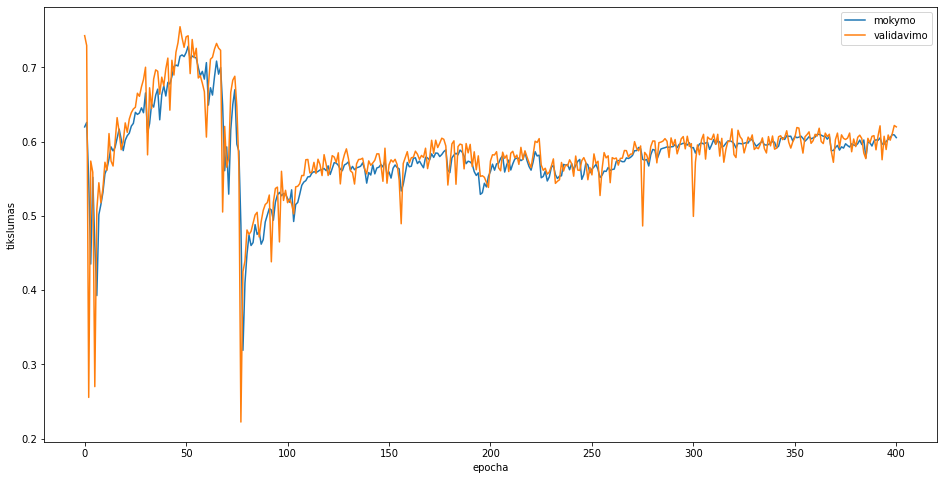

In [55]:
plt.plot(history.history['accuracy'], label = 'mokymo')
plt.plot(history.history['val_accuracy'], label = 'validavimo')
plt.ylabel('tikslumas')
plt.xlabel('epocha')
plt.legend()
plt.savefig(f'./plots/{DATA}_{MODEL_SUFFIX}_accuracy.png')
plt.show()

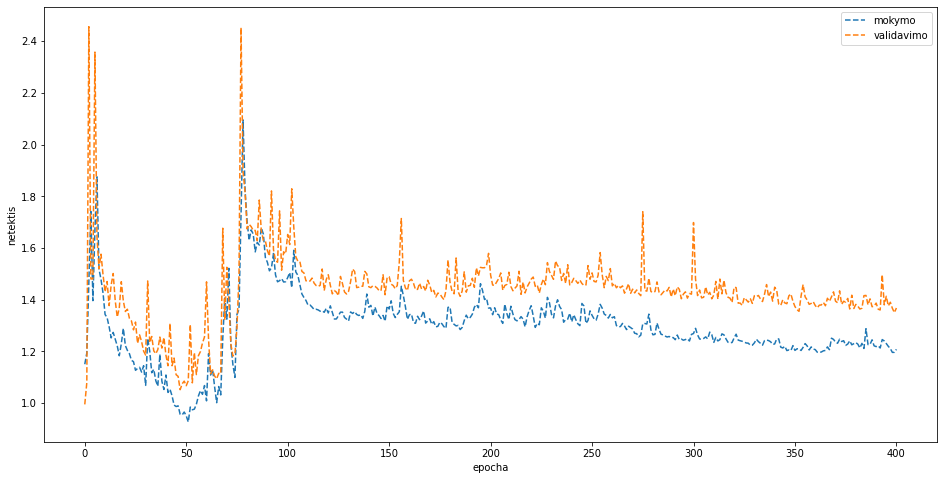

In [56]:
plt.plot(history.history['loss'], '--', label = 'mokymo')
plt.plot(history.history['val_loss'], '--', label = 'validavimo')
plt.ylabel('netektis')
plt.xlabel('epocha')
plt.legend()
plt.savefig(f'./plots/{DATA}_{MODEL_SUFFIX}_loss.png')
plt.show()

In [57]:
model.save(f'./models/{DATA}_{MODEL_SUFFIX}')

INFO:tensorflow:Assets written to: ./models/integrase_5_random_randomized/assets


In [58]:
batch_size = 64      # Batch size for training.
patience = 1000        # Patience for EarlyStop
epochs = 4000         # Number of epochs to train for.
rand_rate = np.full((len(X)), 0.0)
rand_rate.shape

(16032,)